In [1]:
import os
os.getcwd()

'/Users/jinyanxiang/Desktop/Github/Inequality_sharing_economy_og/experiments'

In [72]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [3]:
import numpy as np
import pandas as pd 
import scipy
from scipy.stats import chi2

import pingouin as pg
from pingouin import anova
import matplotlib.pyplot as plt

In [9]:
#read the dataframe
df = pd.read_csv('E4_inequality_SE_lodge_moderation.csv')

In [12]:
#add id index
df.reset_index(inplace = True, drop = True)
df['id'] = df.index

In [13]:
df.columns

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q89_First Click',
       'Q89_Last Click', 'Q89_Page Submit', 'Q89_Click Count',
       'Q102_First Click', 'Q102_Last Click', 'Q102_Page Submit',
       'Q102_Click Count', 'quiz_highIn.', 'quiz_lowIn.', 'quiz_lowF.',
       'quiz_highF.', 'Q149_First Click', 'Q149_Last Click',
       'Q149_Page Submit', 'Q149_Click Count', 'quiz_lowIn.2', 'quiz_highIn.2',
       'quiz_lowF.2', 'quiz_highF.2', 'dv_host', 'dv_accept',
       'Q55_First Click', 'Q55_Last Click', 'Q55_Page Submit',
       'Q55_Click Count', 'med_trust', 'med_trustworthy', 'check_inequality',
       'check_familiarity', 'host_exp', 'general_familiarity',
       'general_attitudes', 'econ', 'econ_inequali

In [14]:
def parsedata(focal_con_num, mod_con_num, var_list, df):
    
    df_parsed = df[(df['inequality'] == focal_con_num) & (df['familiarity'] == mod_con_num)]
    
    return df_parsed[var_list]

In [17]:
var_list = ['id','inequality','familiarity','Duration (in seconds)',
            'dv_host', 'dv_accept',
            'med_trust', 'med_trustworthy',
            'check_inequality','check_familiarity']

In [18]:
df_low_low = parsedata(0, 0, var_list, df)
df_low_high = parsedata(0, 1, var_list, df)
df_high_low = parsedata(1, 0, var_list, df)
df_high_high = parsedata(1, 1,var_list, df)

In [19]:
def calculateMahalanobis(df, scale_list):

    
    x = df[scale_list].values
    mu =np.mean(x, axis = 0)
    
    cov = np.cov(x.T)
    
    inv_covmat = np.linalg.inv(cov)
    
    left = np.dot((x-mu), inv_covmat)
    
    mahal = np.dot(left, (x-mu).T)
    
    df['Mahalanobis'] = mahal.diagonal()
    
    dof = x.shape[1]-1
    
    df['p'] = 1 - chi2.cdf(df['Mahalanobis'], dof)
    df['p'] = np.round(df['p'],4)

    return df

In [40]:
scale_list = ['dv_host', 'dv_accept',
              'med_trust', 'med_trustworthy', 
              'check_inequality','check_familiarity']

df_MD = pd.concat([calculateMahalanobis(df_low_low, scale_list),
                   calculateMahalanobis(df_low_high, scale_list),
                   calculateMahalanobis(df_high_low, scale_list),
                   calculateMahalanobis(df_high_high, scale_list)])

df_MD['dv'] = np.mean([df_MD.dv_host.values, df_MD.dv_accept.values], axis = 0)
df_MD['med'] = np.mean([df_MD.med_trust.values, df_MD.med_trustworthy.values], axis = 0)

df_MD.reset_index(inplace = True, drop = True)

In [54]:
def p_value_pattern(df, dv, title):
    
    x = np.arange(0.001, 0.1, 0.001)
    y = np.zeros(x.shape[0])
    
    for i,j in enumerate(x):
        df_MD_selected = df[df['p'] >= j]
        anova_output = df_MD_selected.anova(dv=dv, between=["inequality", "familiarity"]).round(3)
        y[i] = (anova_output['p-unc'][2])
    
    if y.min() <= 0.05:
        cutoff_index = np.where(y <= 0.05)[0][[0]]
        x_cutoff  = x[cutoff_index][0]
        y_cutoff = y[cutoff_index][0]
        
        plt.axvline(x = x_cutoff, ls = ':', ymax = 0.2, color = 'r')
        plt.axhline(y = .05, ls = '--', color = 'r')
        print('the cutoff point for outlier is  {} (the corresponding p-value of the interaction is {})'.format(round(x_cutoff,3),y_cutoff))
    else: 
        print('p-value of the interaction is always > 0.05') 
                                                                                                                 
    print('the sample size is {}'.format(df.shape[0]))
    plt.title(title)
    plt.scatter(x = x, y = y)
    plt.xlabel('outlier_cutoff')
    plt.ylabel('p_value for interaction')
    plt.show()

the cutoff point for outlier is  0.001 (the corresponding p-value of the interaction is 0.002)
the sample size is 394


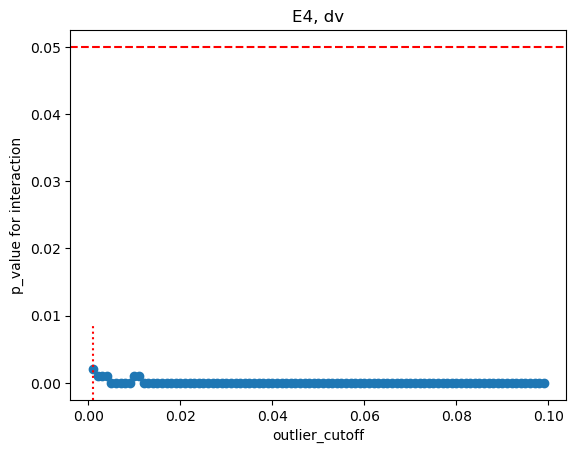

In [55]:
p_value_pattern(df_MD, 'dv','E4, dv')

the cutoff point for outlier is  0.001 (the corresponding p-value of the interaction is 0.031)
the sample size is 394


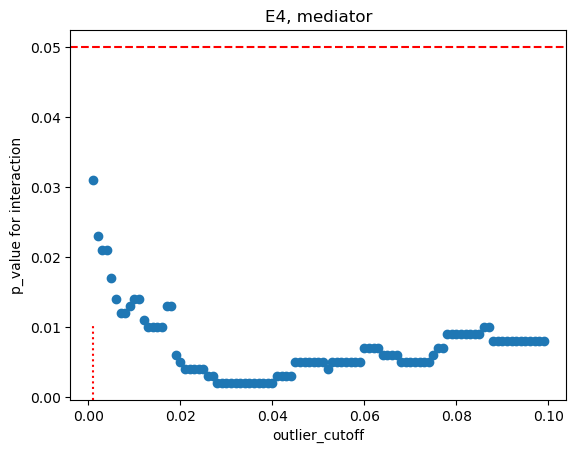

In [56]:
p_value_pattern(df_MD, 'med', 'E4, mediator')

In [50]:
#given the convention, drop the extreme ouliers (p_md <= 0.001) and run do the ANOVA analysis
df_MD[df_MD.p <= 0.001].groupby(by = ['inequality','familiarity']).size()

inequality  familiarity
0           0              6
            1              7
1           0              4
            1              5
dtype: int64

In [51]:
df_MD_no_outliers = df_MD[df_MD.p > 0.001]

In [53]:
df_MD_no_outliers.anova(dv='dv', between=["inequality", "familiarity"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,inequality,42.301,1.0,42.301,32.187,0.000,0.080
1,familiarity,107.174,1.0,107.174,81.549,0.000,0.181
2,inequality * familiarity,12.808,1.0,12.808,9.746,0.002,0.026
3,Residual,483.636,368.0,1.314,NaN,NaN,NaN


In [52]:
df_MD_no_outliers.anova(dv='med', between=["inequality", "familiarity"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,inequality,73.598,1.0,73.598,57.190,0.000,0.135
1,familiarity,70.886,1.0,70.886,55.082,0.000,0.130
2,inequality * familiarity,6.065,1.0,6.065,4.713,0.031,0.013
3,Residual,473.586,368.0,1.287,NaN,NaN,NaN


In [57]:
from pyprocessmacro import Process

In [73]:
process_results = Process(data = df_MD_no_outliers, model = 7, 
                          x = 'inequality', y = 'dv', 
                          m = ['med'], w = 'familiarity')
process_results.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = inequality
    y = dv
    m1 = med
    w = familiarity

Sample size:
372

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = dv 
OLS Regression Summary

     R²  Adj. R²    MSE        F  df1  df2  p-value
 0.4622   0.4578 0.9404 158.5561    2  369   0.0000

Coefficients

             coeff     se       t      p    LLCI   ULCI
Cons        2.5063 0.2482 10.0997 0.0000  2.0199 2.9926
inequality -0.0645 0.1070 -0.6028 0.5470 -0.2743 0.1452
med         0.6827 0.0413 16.5195 0.0000  0.6017 0.7637

-------------------------------------------------------------------------

Outcome = med 
OLS R